In [1]:
!pip install -q qiskit>=0.45.0
!pip install qiskit pylatexenc --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
!pip install -q qiskit-ibm-runtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.9/363.9 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 9.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.3, but you have requests 2.32.4 which is incompatible.


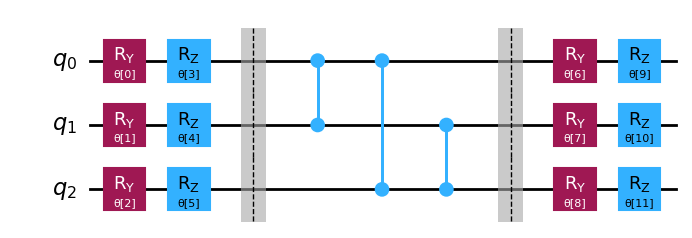

In [3]:
from qiskit.circuit.library import TwoLocal
num_qubits = 3
rotation_blocks = ["ry", "rz"]
entanglement_blocks = "cz"
entanglement = "full"

ansatz = TwoLocal(num_qubits, rotation_blocks, entanglement_blocks, entanglement, reps=1, insert_barriers=True)
ansatz.decompose().draw('mpl')

as seen the circuit has 12 parameters

In [4]:
num_params = ansatz.num_parameters
num_params

12

In [5]:
#transpilation
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
backend_answer=FakeSherbrooke()
optimization_level_answer=3
pm = generate_preset_pass_manager(backend=backend_answer,optimization_level=optimization_level_answer)
isa_circuit = pm.run(ansatz)

In [6]:
#defining the hamiltonian
from qiskit.quantum_info import SparsePauliOp
pauli_op = SparsePauliOp(['ZII', 'IZI', 'IIZ'])
hamiltonian_isa = pauli_op.apply_layout(layout=isa_circuit.layout)

In [24]:
def cost_func(params, ansatz, hamiltonian, estimator, callback_dict):

    pubs = [(ansatz, hamiltonian, params)]
    result = estimator.run(pubs=pubs).result()  #estimator calculates the expectation value of a given operator in this case hamiltonian
    energy = result[0] #energy is the cost function here

    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = params
    callback_dict["cost_history"].append(energy)


    print(energy)
    return energy

In [14]:
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session
from google.colab import userdata

IBM_API_KEY = userdata.get('API')

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token=IBM_API_KEY
)

# Pick a backend
backend = service.backend("ibm_sherbrooke")
estimator = Estimator

<ipython-input-14-2219183239>:7: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService(


In [9]:
callback_dict = {
    "prev_vector": None,    #last parameter vector used
    "iters": 0,             #number of iterations
    "cost_history": [],     #cost at each step
}

In [26]:
import numpy as np
with Session(backend=backend) as session:
    estimator = Estimator()
    num_params = 12  # for example
    x0 = 2 * np.pi * np.random.random(num_params)
    print("Initial parameter vector (12):", x0)
    energy = cost_func(params=x0, ansatz=isa_circuit, hamiltonian=hamiltonian_isa, estimator=estimator, callback_dict=callback_dict)
    print("Final energy is",energy)

Initial parameter vector (12): [2.64798265 0.91773835 6.18426223 3.53538956 2.84584973 4.7754887
 0.07263547 3.04639753 5.91846899 0.1842232  2.18626143 5.7283848 ]


/usr/local/lib/python3.11/dist-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:1129: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)


PubResult(data=DataBin(evs=np.ndarray(<shape=(), dtype=float64>), stds=np.ndarray(<shape=(), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(), dtype=float64>)), metadata={'shots': 4096, 'target_precision': 0.015625, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32})
Final energy is (PubResult(data=DataBin(evs=np.ndarray(<shape=(), dtype=float64>), stds=np.ndarray(<shape=(), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(), dtype=float64>)), metadata={'shots': 4096, 'target_precision': 0.015625, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32}), PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(), dtype=float64>), stds=np.ndarray(<shape=(), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(), dtype=float64>)), metadata={'shots': 4096, 'target_precision': 0.015625, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 